# EDA

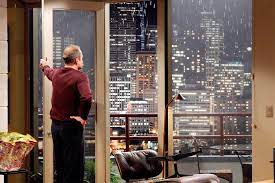

In [ ]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
import statsmodels.formula.api as smf
import folium
import geopandas as gpd

from matplotlib.ticker import PercentFormatter


plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Import Data

In [ ]:
# Import your data
url = 'data/housing.csv' #replace with your data's url
df_housing = pd.read_csv(url)
df_housing.head()

# Data integrity checks

In [ ]:
# Check for duplicates
print(f"Number of duplicate rows: {df_housing.duplicated().sum()}")

In [ ]:
# Check readability and formatting of column names, if need be: change (not necessary here)
df_housing.columns

In [ ]:
# Set date to datetime
df_housing['date'] = pd.to_datetime(df_housing['date'], format='%Y-%m-%d')
print(df_housing['date'].dtypes)

In [ ]:
# Starting df cleaning
df_housing_cleaned = df_housing.copy()

# Removing the last 2 rows as they are duplicates
df_housing_cleaned = df_housing_cleaned.drop(['house_id', 'id.1'], axis=1)
df_housing_cleaned.head()

In [ ]:
# Check dytpes - start converting categorical variables to appropriate type
df_housing_cleaned.dtypes

# Convert categorical variables
#zipcode
df_housing_cleaned['zipcode'] = df_housing_cleaned['zipcode'].astype('category')
#condition
df_housing_cleaned['condition'] = df_housing_cleaned['condition'].astype('category')
#grade 
df_housing_cleaned['grade'] = pd.Categorical(df_housing_cleaned['grade'], categories=range(3, 14), ordered=True)

In [ ]:
# Check NaNs
df_housing_cleaned.isna().sum()

# Percentage of NaN per column
msno.bar(df_housing_cleaned)
msno.matrix(df_housing_cleaned)

# Missing percentage per column
missing_percentage = df_housing_cleaned.isna().mean() * 100
print(missing_percentage)

In [ ]:
# Create a new column to keep track of originally missing values 
df_housing_cleaned['view_missing'] = df_housing_cleaned['view'].isna()
df_housing_cleaned['sqft_basement_missing'] = df_housing_cleaned['sqft_basement'].isna()
df_housing_cleaned['yr_renovated_missing'] = df_housing_cleaned['yr_renovated'].isna()
df_housing_cleaned['waterfront_missing'] = df_housing_cleaned['waterfront'].isna()

# optional: check
df_housing_cleaned.columns

# Missing Values

Handling them by imputation

In [ ]:
# NaNs in view: 
# Define a function for location-based imputation (using longitude and latitude), set radius as needed
def impute_view_by_location(df, lat, long, radius=0.01):
    """Imputes 'view' based on the mode of similar locations."""

    similar_locations = df[
        (abs(df['lat'] - lat) <= radius) &
        (abs(df['long'] - long) <= radius)
    ]

    if not similar_locations.empty:  # Check if similar locations were found
        if not similar_locations['view'].isnull().all():  # Check if not all similar properties are null for "view"
             return similar_locations['view'].mode()[0]  # Use mode as 'view' is categorical
    return np.nan  # Return NaN if no similar locations or all 'view' values are NaN

# Impute 'view' values 
for index, row in df_housing_cleaned[df_housing_cleaned['view'].isnull()].iterrows():  # Only iterate over rows with missing 'view'
    imputed_view = impute_view_by_location(df_housing_cleaned, row['lat'], row['long'])
    df_housing_cleaned.loc[index, 'view'] = imputed_view
    print(f'imputed {imputed_view} at index {index}')

# Verify the imputation (check how many NaNs remain)
print("\nRemaining NaN values in 'view' after imputation:", df_housing_cleaned['view'].isna().sum())

In [ ]:
# Impute NaN from sqft_basement by using sqft_living (full house) and sqft_above (house w/o basement)
df_housing_cleaned['sqft_basement'] = np.where(df_housing_cleaned['sqft_basement'].isnull(),
                                               df_housing_cleaned['sqft_living'] - df_housing_cleaned['sqft_above'],
                                               df_housing_cleaned['sqft_basement'])

# Verify the imputation: 
df_housing_cleaned['sqft_basement'].describe()

In [ ]:
# Impute missing waterfront 
# Define a function for location-based imputation for waterfront
def impute_waterfront_by_location(df, lat, long, radius=0.03):
    """Imputes 'waterfront' based on the mode of similar locations."""
    
    similar_locations = df[
        (abs(df['lat'] - lat) <= radius) &
        (abs(df['long'] - long) <= radius)
    ]
    
    if not similar_locations.empty:  # Check if similar locations were found
        if not similar_locations['waterfront'].isnull().all():  # Check if not all similar properties are null for "waterfront"
            return similar_locations['waterfront'].mode()[0]  # Use mode as 'waterfront' is categorical
    return np.nan  # Return NaN if no similar locations or all 'waterfront' values are NaN

# Apply the imputation function
for index, row in df_housing_cleaned[df_housing_cleaned['waterfront'].isnull()].iterrows():  # Only iterate over rows with missing 'waterfront'
    imputed_waterfront = impute_waterfront_by_location(df_housing_cleaned, row['lat'], row['long'])
    df_housing_cleaned.loc[index, 'waterfront'] = imputed_waterfront
    print(f'Imputed {imputed_waterfront} at index {index}')

# Verify the imputation (check how many NaNs remain)
print("\nRemaining NaN values in 'waterfront' after imputation:", df_housing_cleaned['waterfront'].isna().sum())

In [ ]:
# Define a function for criteria-based imputation for yr_renovated with year range
def impute_yr_renovated_by_criteria(df, grade, condition, yr_built):
    """Imputes 'yr_renovated' based on the median of properties with similar grade, condition, and a range of yr_built."""
    
    similar_locations = df[
        (df['grade'] == grade) &
        (df['condition'] == condition) &
        (df['yr_built'].between(yr_built - 30, yr_built + 30))  # Allow +/- 30 years; adjust as needed 
    ]
    
    if not similar_locations.empty:  # Check if similar properties were found
        if not similar_locations['yr_renovated'].isnull().all():  # Check if not all similar properties are null for "yr_renovated"
            return int(similar_locations['yr_renovated'].median())  # Use median for imputation and convert to int
    return np.nan  # Return NaN if no similar properties or all 'yr_renovated' values are NaN

# Apply the imputation function
for index, row in df_housing_cleaned[df_housing_cleaned['yr_renovated'].isnull()].iterrows():  # Only iterate over rows with missing 'yr_renovated'
    imputed_yr_renovated = impute_yr_renovated_by_criteria(
        df_housing_cleaned, 
        row['grade'], 
        row['condition'], 
        row['yr_built']  # Pass the criteria for filtering
    )
    df_housing_cleaned.loc[index, 'yr_renovated'] = imputed_yr_renovated
    print(f'Imputed {imputed_yr_renovated} at index {index}')

# Verify the imputation (check how many NaNs remain)
print("\nRemaining NaN values in 'yr_renovated' after imputation:", df_housing_cleaned['yr_renovated'].isna().sum())

In [ ]:
# Final NaN check 
missing_percentage = df_housing_cleaned.isna().mean() * 100
print(missing_percentage)

# Proceed with data formatting 

In [ ]:
# Converting data types (cont.) - now columns with originally missing values
# waterfront - convert to bool
df_housing_cleaned['waterfront'] = df_housing_cleaned['waterfront'].astype('bool')
# view - convert to category
df_housing_cleaned['view'] = df_housing_cleaned['view'].astype('bool')

In [ ]:
# Convert entries into readable formats
# Clean yr_renovated by dividing by 10 and rounding to nearest integer
df_housing_cleaned['yr_renovated'] = (df_housing_cleaned['yr_renovated'] / 10).round()
# Set yr_renovated to 0 where it's NaN, then convert to integer
df_housing_cleaned['yr_renovated'] = df_housing_cleaned['yr_renovated'].fillna(0).astype(int)
# Verification: Check unique values to ensure they are now four-digit years
print("Unique values in 'yr_renovated':", df_housing_cleaned['yr_renovated'].unique())

In [ ]:
# Final: check data types
df_housing_cleaned.dtypes

# Feature Engineering

In [ ]:
# Create a renovated column: stores info if or if not the property was renovated (bool)
df_housing_cleaned['renovated'] = (df_housing_cleaned['yr_renovated'] != 0).astype(bool)

# Verify 
df_housing_cleaned['renovated'].value_counts()

In [ ]:
# Create a property_age column: stores the current age of the property
current_year = 2024

# Create column: property age
df_housing_cleaned['property_age'] = current_year - df_housing_cleaned['yr_built']

# Verify
df_housing_cleaned['property_age'].head()

In [ ]:
# Create a renovation_age column: calculate the age of property at time point of renovation; if not renovated, set to 0
df_housing_cleaned['renovation_age'] = df_housing_cleaned.apply(
    lambda row: row['yr_renovated'] - row['yr_built'] if row['yr_renovated'] != 0 else 0,
    axis=1
)

# Verify
print(df_housing_cleaned[['yr_built', 'yr_renovated', 'renovation_age']].head())

# Identifying and handling Outliers

In [ ]:
# Use IQR method to check for outliers in numeric columns
def detect_outliers_iqr(df, columns):
    """Detect outliers in specified columns using the IQR method."""
    outliers_indices = {}

    for column in columns:
        if df[column].dtype in ['int64', 'float64']:    # Only consider numeric columns
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)  
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Identify outliers:
            outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
            outliers_indices[column] = outliers.index.tolist()

            print(f'Column: {column}, Outliers: {len(outliers)}')

    return outliers_indices

# Specify columns to check for outliers
columns_to_check = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'price']

# Call function
outliers = detect_outliers_iqr(df_housing_cleaned, columns_to_check)
print(outliers)

As I see a lot of outliers, I'm reconsidering this approach and instead, opt to look at the distribution of my numeric feature columns to gain more substantial insights.

In [ ]:
# Specify columns to plot histograms
columns_to_plot = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built']

# Create histograms
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(3, 2, i)
    plt.hist(df_housing_cleaned[column], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Heavily right skewed data is to be expected from real estate data, where a few luxury properties shift the distribution. As such, identifying outliers with IQR is not an ideal approach. 

In [ ]:
# Look at categorical columns: visualize 
for col in df_housing_cleaned.select_dtypes(include='category').columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=col, data=df_housing_cleaned, order=sorted(df_housing_cleaned[col].unique()))
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Bedrooms outlier: identification
df_housing_cleaned['bedrooms'].unique()

# Show row with 33 bedrooms to see if property is very large/33 bedrooms makes sense given the rest of the data
df_housing_cleaned[df_housing_cleaned['bedrooms'] == 33] # Probably a data entry error 

# Impute a more sensible value for the outlier
# Define outlier properties
bedroom_outlier_long = -122.331
bedroom_outlier_lat = 47.6878

# Define a radius (in degrees) to search for similar properties
radius = 0.01   # approx. 1km radius

# Impute data from similar properties (similar sqft + location)
similar_properties = df_housing_cleaned[
    (df_housing_cleaned['sqft_living'] >= 1500) & (df_housing_cleaned['sqft_living'] <= 1700) 
    & (df_housing_cleaned['long'] - bedroom_outlier_long <= radius) 
    & (df_housing_cleaned['lat'] - bedroom_outlier_lat <= radius)
]

# Check missing values in similar properties
print(similar_properties['bedrooms'].isna().sum())

# Calculate typical number of bedrooms
typical_bedrooms = similar_properties['bedrooms'].median()  # Use median to be less sensitive to other potential outliers
print(typical_bedrooms)

# Locate the index of the outlier row
outlier_index = df_housing_cleaned[df_housing_cleaned['bedrooms'] == 33].index

# Impute the outlier value
df_housing_cleaned.loc[outlier_index, 'bedrooms'] = typical_bedrooms

# Verify (optional)
print(df_housing_cleaned.loc[outlier_index, 'bedrooms'])

# Data Analysis and visualization 
Main goal: Identify suitable properties, strategize real estate market opportunities for investment returns
Our client:
- high budget
- wants to show off
- timing to buy: within 1 month
- waterfront
- renovated
- high grades
- resell within 1 year

## Compare waterfront and non-waterfront luxury properties

In [ ]:
# Define thresholds (price, grade, renovated) in accordance with client's requirements 
price_threshold = df_housing_cleaned['price'].quantile(0.9)  # Top 10% most expensive properties
grade_threshold = [10, 11, 12, 13]  # Luxury properties

# Filter properties based on client's requirements: price, grade, renovated + waterfront -> do the same as with waterfront
luxury_properties_with_waterfront = df_housing_cleaned[
    (df_housing_cleaned['price'] >= price_threshold) &          # High price property
    (df_housing_cleaned['waterfront'] == 1) &                   # Waterfront property
    (df_housing_cleaned['grade'].isin(grade_threshold)) &       # High grade, i.e. luxury property
    (df_housing_cleaned['renovated'])                           # Renovated: yes
]

# Check (optional)
luxury_properties_with_waterfront['zipcode'].unique()

In [ ]:
# Define control sample: luxury properties without waterfront 
# Define thresholds (set comparable to waterfront properties to match the sample in features)
price_threshold = df_housing_cleaned['price'].quantile(0.9)  # Top 10% most expensive properties
grade_threshold = [10, 11, 12, 13]  # set as needed

# Define desired zipcode
target_zipcodes = luxury_properties_with_waterfront['zipcode']

# Convert to categorical variable
target_zipcodes = pd.Categorical(target_zipcodes)

# Filter properties for comparison: similar price, high grade, renovated, WITHOUT waterfront
luxury_properties_without_waterfront = df_housing_cleaned[
    (df_housing_cleaned['price'] >= price_threshold) &      # High budget
    (df_housing_cleaned['waterfront'] == 0) &               # Non-waterfront property
    (df_housing_cleaned['grade'].isin(grade_threshold) ) &      # High grade
    (df_housing_cleaned['renovated']) &                            # Recently renovated
    (df_housing_cleaned['zipcode'].isin(target_zipcodes)) 
]

# Verify (optional)
luxury_properties_without_waterfront['grade'].unique()

For comparison: the following analyses are done on all (i.e. not just luxury) properties with waterfront feature

In [ ]:
# All waterfront properties 
# Select based on waterfront yes/no
all_properties_with_waterfront = df_housing_cleaned[      
    (df_housing_cleaned['waterfront'] == 1)            # Waterfront property
]

# Verify (optional)
all_properties_with_waterfront.value_counts

## Visualization

Exploring the relationship between luxury waterfront properties and their market prices

In [ ]:
# Combine DataFrames: luxury properties with and without waterfront
lux_combined_df = pd.concat([
    luxury_properties_with_waterfront.assign(waterfront='Waterfront'),
    luxury_properties_without_waterfront.assign(waterfront='Non-Waterfront')
])

# Set style and context
sns.set_style('whitegrid')
sns.set_context('paper')
plt.figure(figsize=(12, 7))  # adjust figure size as needed 

# Define custom colors
palette_colors = ['#6585aa', '#85aa65']  # Blue for waterfront, green for non-waterfront

# Calculate means and SEM
means = lux_combined_df.groupby('waterfront')['price'].mean()
sems = lux_combined_df.groupby('waterfront')['price'].sem()  # Standard Error of the Mean

# Create the bar chart
barplot= sns.barplot(
            x='waterfront', 
            y='price', 
            data=lux_combined_df, 
            estimator=np.mean, 
            ci='sd', 
            capsize=0.2, 
            palette=palette_colors,
            edgecolor="navy",
            )

# Add individual points with color matching 
sns.stripplot(x='waterfront', 
              y='price', 
              data=lux_combined_df,
              hue='waterfront', 
              palette=palette_colors, 
              size=7, 
              jitter=0.2, 
              edgecolor="black", 
              linewidth=1,
              alpha=0.4
              )

# Change y-axis format to display values in millions
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f} M'))

# highlight key differences
mean_diff = means[1] - means[0]

# Annotate bar with mean prices
for i, bar in enumerate(barplot.patches):
    bar_height = bar.get_height()
    plt.annotate(f'${bar_height/1e6:.1f}M', 
                 (bar.get_x() + bar.get_width() / 2, 0), 
                 ha='center', 
                 va='bottom', 
                 fontsize=13, 
                 color='navy', 
                 fontweight='bold')

# Annotate the difference
difference_position_y = max(means) + 1e5  # Set position slightly above the higher mean
plt.annotate(f'Difference: ${mean_diff/1e6:.1f}M', 
             xy=(0.5, difference_position_y),  # Position at the center on the x-axis
             xytext=(0.5, difference_position_y + 1e5),  # Offset above the bar
             arrowprops=dict(facecolor='black', arrowstyle="->", lw=1),
             fontsize=14,
             color='red',
             fontweight='bold',
             ha='center')  # Center align the annotation

# Labels and Title
plt.title('Luxury Properties: Average Price\nWaterfront vs. Non-Waterfront', fontsize=20, pad=20)
plt.xlabel('Property Type', fontsize=16)
plt.ylabel('Average Price (Million USD)', fontsize=16, labelpad=20)

# x and y-axis labels
plt.xticks(rotation=0, ha='center', fontsize=14)
plt.yticks(fontsize=14)

# Enhance grid for readability 
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Adjust layout for a clean look
plt.tight_layout()

# show the plot
plt.show()



In [ ]:
# "Regular" Properties with and without Waterfront
# Set style and context
sns.set_palette('pastel')
sns.set_style('whitegrid')
sns.set_context('paper')
plt.figure(figsize=(10, 8))  # adjust figure size as needed 

# Calculate means and SEM
means = df_housing_cleaned.groupby('waterfront')['price'].mean()
sems = df_housing_cleaned.groupby('waterfront')['price'].sem()  # Standard Error of the Mean

# Create the bar chart
sns.barplot(x='waterfront', 
            y='price', 
            data=df_housing_cleaned, 
            estimator=np.mean, 
            ci='sd', 
            capsize=.2, 
            palette="pastel",
            edgecolor="navy",
            )

# Add individual points
sns.stripplot(x='waterfront', 
              y='price', 
              data=df_housing_cleaned, 
              color=".3", 
              size=7, 
              jitter=0.3, 
              edgecolor="gray", 
              linewidth=0.5,
              alpha=0.4)

# Change y-axis format to display values in millions
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f} M'))

# Labels and Title
plt.title('Price Comparison of Properties: \nWaterfront vs. No Waterfront', fontsize=16)
plt.xlabel('Property Type', fontsize=14)
plt.ylabel('Price (USD)', fontsize=14, labelpad=20)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

# Show the plot
plt.show()

## Location: compare waterfront price premium in different areas

Identifying neighbourhoods with substantial price impacts on luxury waterfront properties

In [ ]:
# Calculate the mean price for each zip code in both DataFrames
mean_with_waterfront = luxury_properties_with_waterfront.groupby('zipcode')['price'].mean().reset_index()
mean_without_waterfront = luxury_properties_without_waterfront.groupby('zipcode')['price'].mean().reset_index()

# Rename columns for clarity
mean_with_waterfront.columns = ['zipcode', 'mean_price_with_waterfront']
mean_without_waterfront.columns = ['zipcode', 'mean_price_without_waterfront']

# Merge the results and compute the percentage difference
zipcode_means = pd.merge(mean_with_waterfront, mean_without_waterfront, on='zipcode', how='inner')
zipcode_means['percentage_difference'] = (
    (zipcode_means['mean_price_with_waterfront'] - zipcode_means['mean_price_without_waterfront']) /
    zipcode_means['mean_price_without_waterfront']
) * 100

# Drop rows with any NaN values
zipcode_means = zipcode_means.dropna(axis=0)

# Display the cleaned df 
print(zipcode_means)

## Map: create a visualization for in-/decreases in price in different areas

In [402]:
# Define the starting point for the map (e.g., center of Seattle)
m = folium.Map(location=[47.6062, -122.3321], zoom_start=12)

# Load the corrected Seattle GeoJSON data
KingCounty_zips_df = gpd.read_file('GeoJSON/Zipcodes.geojson')

# Define custom color bins and corresponding colors
def get_color_by_percentage(diff):
    if diff < 0:
        return '#a6cee3'       # Negative change, light blue
    elif 0 <= diff < 50:
        return '#1f78b4'    # Slight increase (0% - 50%), soft teal
    elif 50 <= diff <= 100:
        return '#33a02c'     # Moderate increase (50% - 100%), medium green
    else:
        return '#006837' # Large increase (>100%), dark green

# Add a new column to merged_df with colors based on percentage_difference
zipcode_means['color'] = zipcode_means['percentage_difference'].apply(get_color_by_percentage)

# Function to style each feature in GeoJSON based on ZIP code color
def style_function(feature):
    zipcode = int(feature['properties']['ZIPCODE'])
    row = zipcode_means[zipcode_means['zipcode'] == zipcode]
    if not row.empty:
        color = row.iloc[0]['color']
    else:
        color = 'gray'  # default color if ZIP code not found in data
    return {
        'fillColor': color,
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7
    }

# Add GeoJSON layer with custom styling to the map
folium.GeoJson(
    data='GeoJSON/Zipcodes.geojson',
    name='choropleth',
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(
        fields=['ZIPCODE'],
        aliases=['ZIP Code: '],
        localize=True
    )
).add_to(m)

# List of properties with coordinates
properties = [
    {"name": "Property 1 - 3910", "latitude": 47.650, "longitude": -122.214, "price": 7060000.000},
    {"name": "Property 2 - 8085", "latitude": 47.557, "longitude": -122.210, "price": 4670000.000},
    {"name": "Property 3 - 2862", "latitude": 47.593, "longitude": -122.287, "price": 3600000.000},
    {"name": "Property 4 - 18185", "latitude": 47.608, "longitude": -122.110, "price": 3300000.000},
    {"name": "Property 5 - 8775", "latitude": 47.547, "longitude": -122.197, "price": 1800000.000},
    {"name": "Property 6 - 15678", "latitude": 47.442, "longitude": -122.354, "price": 1640000.000}
]

# Define a function to get the color based on the price
def get_color(price):
    if price < 2000000:
        return 'green'
    elif 2000000 <= price <= 4000000:
        return 'orange'
    elif 4000000 <= price <= 6000000:
        return 'red'
    else:
        return 'darkred'

# Add each property as a marker on the map
for property in properties:
    folium.Marker(
        location=[property["latitude"], property["longitude"]],
        popup=f"{property['name']} - Price: ${property['price']}",
        icon=folium.Icon(color=get_color(property['price']), icon="home")
    ).add_to(m)


# Add a legend to the map
legend_html = '''
<div style="
    position: fixed;
    bottom: 50px;
    left: 50px;
    width: 150px;
    height: 140px;
    background-color: white;
    border:2px solid grey;
    z-index:9999;
    font-size:14px;
    ">
    <div style="text-align: center; font-weight: bold; padding: 5px">Waterfront Price Premium</div>
    <div style="background-color: #a6cee3; height: 20px; line-height:20px; color: black; padding-left: 5px;"> < 0%</div>
    <div style="background-color: #1f78b4; height: 20px; line-height:20px; color: white; padding-left: 5px;">0% - 50%</div>
    <div style="background-color: #33a02c; height: 20px; line-height:20px; color: white; padding-left: 5px;">50% - 100%</div>
    <div style="background-color: #006837; height: 20px; line-height:20px; color: white; padding-left: 5px;"> > 100%</div>
</div>
'''

# Add legend HTML to the map
m.get_root().html.add_child(folium.Element(legend_html))

# Add layer control to toggle between layers
folium.LayerControl().add_to(m)

# Save the map to an HTML file
m.save("percentage_difference_binned_geojson_with_properties.html")

# To view the map, open "percentage_difference_binned_geojson_with_properties.html" in a web browser


## Temporal patterns

Analysing seasonal trends and fluctuations in waterfront luxury property prices

In [ ]:
# Create 'month_sold' column from the 'date' column
df_housing_cleaned['month_sold'] = df_housing_cleaned['date'].dt.month 

# Define a function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply the function to create the 'season' column
df_housing_cleaned['season'] = df_housing_cleaned['month_sold'].apply(get_season)

# Set 'season' as an ordered categorical variable
df_housing_cleaned['season'] = pd.Categorical(
    df_housing_cleaned['season'], 
    categories=['Winter', 'Spring', 'Summer', 'Autumn'], 
    ordered=True
)

# Group by season and waterfront status, calculate average price
seasonal_avg_prices = df_housing_cleaned.groupby(['season', 'waterfront'])['price'].mean().unstack()

# Rename columns for clarity
seasonal_avg_prices.columns = ["Non-Waterfront", "Waterfront"]

plt.figure(figsize=(12, 7))
sns.lineplot(data=seasonal_avg_prices, marker='o', linewidth=3, palette=['#d95f02', '#1b9e77'])

# Set plot title and labels
plt.title('Average Property Prices by Season: \nWaterfront vs. Non-Waterfront Properties', fontsize=18, pad=20)
plt.xlabel('Season', fontsize=16)
plt.ylabel('Average Price [Mio. USD]', fontsize=16, labelpad=20)

# Customize x- and y-axis labels for readability
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Change y-axis format to display values in millions
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f} M'))

# Add annotations for the highest and lowest waterfront property prices
# Calculate the overall average price for waterfront properties
WF_overall_avg_price = seasonal_avg_prices['Waterfront'].mean()

# Add a light green line for the overall average price
plt.axhline(y=WF_overall_avg_price, color='lightgrey', linestyle=':', linewidth=2)

# Annotate the average line
plt.text(
    x=len(seasonal_avg_prices.index) - 1,  # X-coordinate for text (last season)
    y=WF_overall_avg_price,                    # Y-coordinate (average price)
    s=f'Overall Avg: {WF_overall_avg_price / 1e6:.1f}M',  # Annotation text
    color='grey', fontsize=12, ha='left', va='top'  # Text color matches line color
)
# Find the maximum and minimum values for waterfront properties
max_price_season = seasonal_avg_prices['Waterfront'].idxmax()
min_price_season = seasonal_avg_prices['Waterfront'].idxmin()
max_price = seasonal_avg_prices['Waterfront'].max()
min_price = seasonal_avg_prices['Waterfront'].min()

# Calculate percentage deviations
peak_deviation = ((max_price - WF_overall_avg_price) / WF_overall_avg_price) * 100
lowest_deviation = ((min_price - WF_overall_avg_price) / WF_overall_avg_price) * 100

# Annotate the highest point in waterfront prices
plt.text(
    x=list(seasonal_avg_prices.index).index(max_price_season),  # X-coordinate of max season
    y=max_price,                                                # Y-coordinate (max price)
    s=f'+{peak_deviation:.1f}%',                            # Annotation text
    color='#d95f02', fontsize=12, ha='center', va='bottom'      # Text color matches line color, centered, above point
)

# Annotate the lowest point in waterfront prices
plt.text(
    x=list(seasonal_avg_prices.index).index(min_price_season),  # X-coordinate of min season
    y=min_price,                                                # Y-coordinate (min price)
    s=f'-{lowest_deviation:.1f}%',                          # Annotation text
    color='#d95f02', fontsize=12, ha='center', va='top'         # Text color matches line color, centered, below point
)

# Add grid for better readability
plt.grid(True)

# Place the legend to the right of the plot, with larger font size
plt.legend(
    title='Property Type', 
    loc='upper left', 
    bbox_to_anchor=(1, 1),  # Position the legend outside the plot
    fontsize=12,              # Adjust legend font size
    title_fontsize=12
)

# Show the plot
plt.tight_layout()
plt.show()




In [ ]:
# Create 'month_sold' column from the 'date' column
lux_combined_df['month_sold'] = lux_combined_df['date'].dt.month 

# Define a function to map months to seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Apply the function to create the 'season' column
lux_combined_df['season'] = lux_combined_df['month_sold'].apply(get_season)

# Set 'season' as an ordered categorical variable
lux_combined_df['season'] = pd.Categorical(
    lux_combined_df['season'], 
    categories=['Winter', 'Spring', 'Summer', 'Autumn'], 
    ordered=True
)

# Group by season and waterfront status, calculate average price
seasonal_avg_prices = lux_combined_df.groupby(['season', 'waterfront'])['price'].mean().unstack()

# Rename columns for clarity
seasonal_avg_prices.columns = ["Non-Waterfront", "Waterfront"]

plt.figure(figsize=(12, 7))
sns.lineplot(data=seasonal_avg_prices, marker='o', linewidth=3, palette=['#d95f02', '#1b9e77'])

# Set plot title and labels
plt.title('Average Property Prices by Season - Luxury Properties: \nWaterfront vs. Non-Waterfront Properties', fontsize=18, pad=20)
plt.xlabel('Season', fontsize=16)
plt.ylabel('Average Price [Mio. USD]', fontsize=16, labelpad=20)

# Customize x- and y-axis labels for readability
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)

# Change y-axis format to display values in millions
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f} M'))

# Add annotations for the highest and lowest waterfront property prices
# Calculate the overall average price for waterfront properties
WF_overall_avg_price = seasonal_avg_prices['Waterfront'].mean()

# Add a light green line for the overall average price
plt.axhline(y=WF_overall_avg_price, color='lightgrey', linestyle=':', linewidth=2)

# Annotate the average line
plt.text(
    x=len(seasonal_avg_prices.index) - 1,  # X-coordinate for text (last season)
    y=WF_overall_avg_price,                    # Y-coordinate (average price)
    s=f'Waterfront Avg: {WF_overall_avg_price / 1e6:.1f}M',  # Annotation text
    color='grey', fontsize=12, ha='left', va='top'  # Text color matches line color
)
# Find the maximum and minimum values for waterfront properties
max_price_season = seasonal_avg_prices['Waterfront'].idxmax()
min_price_season = seasonal_avg_prices['Waterfront'].idxmin()
max_price = seasonal_avg_prices['Waterfront'].max()
min_price = seasonal_avg_prices['Waterfront'].min()

# Calculate percentage deviations
peak_deviation = ((max_price - WF_overall_avg_price) / WF_overall_avg_price) * 100
lowest_deviation = ((min_price - WF_overall_avg_price) / WF_overall_avg_price) * 100

# Annotate the highest point in waterfront prices
plt.text(
    x=list(seasonal_avg_prices.index).index(max_price_season),  # X-coordinate of max season
    y=max_price,                                                # Y-coordinate (max price)
    s=f'+{peak_deviation:.1f}%',                            # Annotation text
    color='#d95f02', fontsize=12, ha='center', va='bottom'      # Text color matches line color, centered, above point
)

# Annotate the lowest point in waterfront prices
plt.text(
    x=list(seasonal_avg_prices.index).index(min_price_season),  # X-coordinate of min season
    y=min_price,                                                # Y-coordinate (min price)
    s=f'-{lowest_deviation:.1f}%',                          # Annotation text
    color='#d95f02', fontsize=12, ha='center', va='top'         # Text color matches line color, centered, below point
)

# Add grid for better readability
plt.grid(True)

# Place the legend to the right of the plot, with larger font size
plt.legend(
    title='Property Type', 
    loc='upper left', 
    bbox_to_anchor=(1, 1),  # Position the legend outside the plot
    fontsize=12,              # Adjust legend font size
    title_fontsize=12
)

# Show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Add season column
lux_combined_df['month_sold'] = lux_combined_df['date'].dt.month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'
lux_combined_df['season'] = lux_combined_df['month_sold'].apply(get_season)
lux_combined_df['season'] = pd.Categorical(lux_combined_df['season'], categories=['Winter', 'Spring', 'Summer', 'Autumn'], ordered=True)

# Step 2: Calculate average prices by season and waterfront status
seasonal_avg_prices = lux_combined_df.groupby(['season', 'waterfront'])['price'].mean().unstack()
seasonal_avg_prices = seasonal_avg_prices[['Waterfront']]  # Select only Waterfront column
seasonal_avg_prices.columns = ["Waterfront"]

# Calculate the overall average price for waterfront properties
WF_overall_avg_price = seasonal_avg_prices['Waterfront'].mean()

# Determine seasonal max/min prices and calculate deviation percentages
max_price_season = seasonal_avg_prices['Waterfront'].idxmax()
min_price_season = seasonal_avg_prices['Waterfront'].idxmin()
max_price = seasonal_avg_prices['Waterfront'].max()
min_price = seasonal_avg_prices['Waterfront'].min()
peak_deviation = ((max_price - WF_overall_avg_price) / WF_overall_avg_price) * 100
lowest_deviation = ((min_price - WF_overall_avg_price) / WF_overall_avg_price) * 100

# Plotting with enhanced readability
plt.figure(figsize=(12, 7))
sns.lineplot(data=seasonal_avg_prices, marker='o', linewidth=3, color='#1b9e77')  

# Set plot title and labels with increased font size for readability
plt.title('Luxury Waterfront Properties:\nAverage Prices by Season', fontsize=20, pad=20)
plt.xlabel('Season', fontsize=16)
plt.ylabel('Average Price (Million USD)', fontsize=16, labelpad=20)

# Customize x- and y-axis labels for readability
plt.xticks(rotation=0, fontsize=14)  # Keep labels horizontal for seasons
plt.yticks(fontsize=14)

# Format y-axis in millions
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}'))

# Add a horizontal line for the waterfront overall average price
plt.axhline(y=WF_overall_avg_price, color='grey', linestyle=':', linewidth=2)
plt.text(
    x=len(seasonal_avg_prices.index) - 1, 
    y=WF_overall_avg_price - 0.1e6,                    
    s=f'Waterfront Avg: {WF_overall_avg_price / 1e6:.1f}M', 
    color='grey', fontsize=13, ha='left', va='top' 
)

# Annotate maximum and minimum prices for waterfront with deviation percentages
plt.text(
    x=list(seasonal_avg_prices.index).index(max_price_season), 
    y=max_price + 0.1e6,  # Move slightly above the point
    s=f'+ {peak_deviation:.1f}%',                           
    color='navy', fontsize=14, ha='center', va='bottom',
    fontweight='bold'
)
plt.text(
    x=list(seasonal_avg_prices.index).index(min_price_season),
    y=min_price + 0.3e6,  # Move slightly above the point
    s=f'-{lowest_deviation:.1f}%',                          
    color='navy', fontsize=14, ha='center', va='top',
    fontweight='bold'
)

# Additional data labels for each season in Waterfront prices
for season in seasonal_avg_prices.index:
    # Waterfront price annotation
    plt.text(
        x=list(seasonal_avg_prices.index).index(season), 
        y=seasonal_avg_prices.loc[season, "Waterfront"] - 0.15e6,  # Adjusted position slightly below the point
        s=f'{seasonal_avg_prices.loc[season, "Waterfront"] / 1e6:.1f}M',
        color='blue', ha='center', va='top', fontsize=12
    )

# Enhance grid for readability
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Remove legend as it is now redundant
plt.legend().remove()

# Adjust layout for a clean look
plt.tight_layout()
plt.show()


# Statistical Testing

On all properties: numerical features

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

# FIND CORRELATION AMONG NUMERIC FEATURES: STRONGEST EFFECTS ON PRICE - done across all properties (i.e. no pre-selection)
# Select numerical features
numerical_features = df_housing_cleaned.select_dtypes(include=[np.number]).columns.tolist()

# Compute Pearson correlation coefficients
pearson_corr = df_housing_cleaned[numerical_features].corr(method='pearson')

# Compute Spearman correlation coefficients
spearman_corr = df_housing_cleaned[numerical_features].corr(method='spearman')

# Display the correlation matrices
print("Pearson Correlation Coefficients:")
print(pearson_corr['price'].sort_values(ascending=False))

print("\nSpearman Correlation Coefficients:")
print(spearman_corr['price'].sort_values(ascending=False))

Using both Pearson and Spearman provides a more comprehensive understanding of the relationships between numeric features and the target variable (price). If the Pearson correlation is high, but the Spearman is low, it suggests a linear relationship is present but may not encompass all the nuances (like outliers or non-linearity) that Spearman can detect.

On all properties: categorical features

In [ ]:
# Select categorical features
categorical_features = df_housing_cleaned.select_dtypes(include=['category', 'bool']).columns.tolist()

# Function to compute correlation ratio
def correlation_ratio(y, x):
    # Compute the mean price for each category
    categories = np.unique(x)
    return np.sqrt(np.sum([(np.mean(y[x == cat]) - np.mean(y)) ** 2 * np.sum(x == cat) for cat in categories]) / (len(y) * np.var(y)))

# Compute and display correlation ratios for categorical features
correlation_ratios = {}
for cat in categorical_features:
    if cat != 'price':
        corr_ratio = correlation_ratio(df_housing_cleaned['price'], df_housing_cleaned[cat])
        correlation_ratios[cat] = corr_ratio

# Display correlation ratios
print("\nCorrelation Ratios (Eta Squared) for Categorical Features:")
for cat, corr_ratio in sorted(correlation_ratios.items(), key=lambda item: item[1], reverse=True):
    print(f"{cat}: {corr_ratio:.4f}")


In [ ]:
# Perform ANOVA for each categorical feature
anova_results = {}
for cat in categorical_features:
    if cat != 'price':
        groups = [group['price'].values for name, group in df_housing_cleaned.groupby(cat)]
        f_stat, p_value = stats.f_oneway(*groups)
        anova_results[cat] = (f_stat, p_value)

# Display ANOVA results
print("\nANOVA Results for Categorical Features:")
for cat, (f_stat, p_value) in anova_results.items():
    print(f"{cat}: F-statistic = {f_stat:.4f}, p-value = {p_value:.4f}")


ANOVA helps determine whether there are significant differences between groups, while Eta squared quantifies the magnitude of these differences. This combination allows you to not only assess whether a categorical variable is important (through ANOVA) but also understand how impactful it is (through Eta squared).

On luxury properties specifically

In [ ]:
from scipy.stats import ttest_ind

# Run Welch's t-test on property prices between waterfront and non-waterfront properties: Welch's doesn't assume equal variance or sample size 
waterfront_prices = luxury_properties_with_waterfront['price']
non_waterfront_prices = luxury_properties_without_waterfront['price']
t_stat, p_value = ttest_ind(waterfront_prices, non_waterfront_prices, equal_var=False)

print("T-statistic:", t_stat)
print("P-value:", p_value)

Welch's t-test is a variation of the independent samples t-test used to compare the means of two groups. It is specifically designed for situations where the two groups have unequal variances and/or unequal sample sizes.

In [ ]:
# Calculate Cohen's d for effect size 
def cohens_d(group1, group2):
    diff_mean = group1.mean() - group2.mean()
    pooled_sd = np.sqrt((group1.var() + group2.var()) / 2)
    return diff_mean / pooled_sd

effect_size = cohens_d(waterfront_prices, non_waterfront_prices)
print("Effect size (Cohen's d):", effect_size)

In [ ]:
import statsmodels.formula.api as smf

# Combine DataFrames
lux_combined_df = pd.concat([
    luxury_properties_with_waterfront.assign(waterfront='Waterfront'),
    luxury_properties_without_waterfront.assign(waterfront='Non-Waterfront')
])

# Adjust variables in the model formula based on available data
# Price as a function of waterfront status, square footage, and grade, ...
model = smf.ols(formula='price ~ C(waterfront) + sqft_living + grade + view + property_age', data=lux_combined_df).fit()

# Print the summary of the regression
print(model.summary())